<a href="https://colab.research.google.com/github/NanakiOhashi-JP/fingerDetection/blob/main/fingerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# files.upload() # kaggle.json を選択してアップロード

In [ ]:
# !mkdir -p ~/.kaggle # .kaggle ディレクトリがなければ作成
# !cp kaggle.json ~/.kaggle/ # kaggle.json を .kaggle ディレクトリにコピー
# !chmod 600 ~/.kaggle/kaggle.json # パーミッションを設定 (所有者のみ読み書き可能)

In [ ]:
# !kaggle datasets download koryakinp/fingers

In [ ]:
# !unzip fingers.zip -d ./fingers_dataset

データの前処理

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split # 検証データの分割に使う

# データセットのルートディレクトリパス
dataset_root = './fingers_dataset'
# 画像ファイルが格納されている最上位のディレクトリ
base_image_dir = os.path.join(dataset_root, 'fingers')

# 訓練データとテストデータのパスを明確に定義
train_data_dir = os.path.join(base_image_dir, 'train')
test_data_dir = os.path.join(base_image_dir, 'test')

# 設定パラメータ
IMG_HEIGHT = 96  # 画像の高さ
IMG_WIDTH = 96   # 画像の幅
NUM_CLASSES = 6  # 指の本数（0から5までなので6クラス）
BATCH_SIZE = 32  # 一度に処理する画像の枚数

# --- ファイルパスとラベルのリストを作成（訓練データ用）---
train_image_paths = []
train_labels = []

if not os.path.exists(train_data_dir):
    print(f"Error: Train data directory '{train_data_dir}' does not exist.")
else:
    print(f"Scanning training images in: {train_data_dir}")
    for filename in os.listdir(train_data_dir):
        if filename.endswith(".png"):
            try:
                # ファイル名からラベルを抽出 (例: "0000_0L.png" -> "0")
                label_char = filename[-6]
                label = int(label_char)
                if 0 <= label < NUM_CLASSES:
                    train_image_paths.append(os.path.join(train_data_dir, filename))
                    train_labels.append(label)
                else:
                    print(f"Skipping train file with invalid label: {filename} (extracted: {label_char})")
            except (ValueError, IndexError):
                print(f"Skipping train file with unparseable label: {filename}")

print(f"Found {len(train_image_paths)} training images.")


# --- ファイルパスとラベルのリストを作成（テストデータ用）---
test_image_paths = []
test_labels = []

if not os.path.exists(test_data_dir):
    print(f"Error: Test data directory '{test_data_dir}' does not exist.")
else:
    print(f"Scanning test images in: {test_data_dir}")
    for filename in os.listdir(test_data_dir):
        if filename.endswith(".png"):
            try:
                label_char = filename[-6]
                label = int(label_char)
                if 0 <= label < NUM_CLASSES:
                    test_image_paths.append(os.path.join(test_data_dir, filename))
                    test_labels.append(label)
                else:
                    print(f"Skipping test file with invalid label: {filename} (extracted: {label_char})")
            except (ValueError, IndexError):
                print(f"Skipping test file with unparseable label: {filename}")

print(f"Found {len(test_image_paths)} test images.")

# NumPy配列に変換
train_image_paths = np.array(train_image_paths)
train_labels = np.array(train_labels)
test_image_paths = np.array(test_image_paths)
test_labels = np.array(test_labels)


# --- 訓練データから検証データを分割 (stratify を使用) ---
# train_image_paths と train_labels をさらに訓練用と検証用に分割します。
# test_size=0.2 で20%を検証データに。stratify=train_labels でクラス比率を維持。
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"\nFinal Train images: {len(train_image_paths)}, Validation images: {len(val_image_paths)}")
print(f"Test images: {len(test_image_paths)}")

print(f"Example train label: {train_labels[0]}, Path: {train_image_paths[0]}")
print(f"Example test label: {test_labels[0]}, Path: {test_image_paths[0]}")


# --- TensorFlow Dataset を作成 ---
# 画像の読み込み、前処理を行うヘルパー関数
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1) # PNGとしてデコード
    img = tf.image.convert_image_dtype(img, tf.float32) # float32に変換 (0-1に正規化される)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) # リサイズ
    label = tf.one_hot(label, depth=NUM_CLASSES) # ワンホットエンコーディング
    return img, label

# データ拡張（訓練データのみに適用）
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image) # 左右反転
    image = tf.image.random_brightness(image, max_delta=0.1) # 明るさ調整
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1) # コントラスト調整
    # tf.image.random_zoom や random_rotation は別途実装が必要な場合があるため、今回はシンプルに
    return image, label


# 訓練データセット
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) # データ拡張を適用
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 検証データセット (データ拡張なし)
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# テストデータセット (データ拡張なし)
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


print("\nTensorFlow Datasets created.")
print(f"Train Dataset: {train_ds}")
print(f"Validation Dataset: {val_ds}")
print(f"Test Dataset: {test_ds}")

# 各データセットから最初のバッチを試しに取得して形状を確認
print("\n--- Checking Dataset Batch Shapes ---")
for image_batch, label_batch in train_ds.take(1):
    print(f"Train Batch - Image shape: {image_batch.shape}, Label shape: {label_batch.shape}")
    print(f"Example labels (one-hot encoded) from train_ds: \n{label_batch[:5].numpy()}")
for image_batch, label_batch in val_ds.take(1):
    print(f"Validation Batch - Image shape: {image_batch.shape}, Label shape: {label_batch.shape}")
for image_batch, label_batch in test_ds.take(1):
    print(f"Test Batch - Image shape: {image_batch.shape}, Label shape: {label_batch.shape}")

Scanning training images in: ./fingers_dataset/fingers/train
Found 18000 training images.
Scanning test images in: ./fingers_dataset/fingers/test
Found 3600 test images.

Final Train images: 14400, Validation images: 3600
Test images: 3600
Example train label: 5, Path: ./fingers_dataset/fingers/train/f866d61f-af7c-4c7e-879d-30e0b1c9df28_5R.png
Example test label: 4, Path: ./fingers_dataset/fingers/test/8e907ffe-0f56-4f23-a27f-32c13316a2e5_4L.png

TensorFlow Datasets created.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>


モデルの構築

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2 # 軽量モデルの代表

# 事前学習済みMobileNetV2をベースモデルとしてロード
# include_top=False: MobileNetV2の最終の分類層を含めない（私たちのタスクに合わせて変更するため）
# weights='imagenet': ImageNetデータセットで学習済みの重みを使用（転移学習）
# input_shape: モデルの入力サイズ（前処理で設定したIMG_HEIGHT, IMG_WIDTH, 3に合わせる）
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), # 前処理で設定した画像サイズ
    include_top=False,
    weights=None
)

# ベースモデルの層をフリーズ（凍結）する
# これにより、事前学習済みの重みが学習中に更新されないようにします。
# 転移学習の初期段階では、フリーズすることで安定した学習が期待できます。
base_model.trainable = False

# 新しい分類ヘッドを構築
# ベースモデルの出力に新しい層を追加して、私たちの指カウントタスクに適合させる
x = base_model.output
x = GlobalAveragePooling2D()(x) # 空間次元を平均化し、特徴マップを1次元ベクトルに変換
x = Dense(128, activation='relu')(x) # 新しい全結合層（隠れ層）
x = Dropout(0.5)(x) # 過学習を防ぐためのDropout
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # 最終出力層 (6クラス分類)

# 新しいモデルを定義
model = Model(inputs=base_model.input, outputs=predictions)

# モデルのコンパイル
# optimizer: 最適化アルゴリズム。Adamが一般的で高性能。
# loss: 損失関数。ワンホットエンコーディングされたラベルには 'categorical_crossentropy' を使用。
# metrics: 評価指標。 'accuracy' を使用して、モデルの正解率を追跡。
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# モデルのサマリを表示
# 各層の名前、出力形状、パラメータ数などが表示される
model.summary()

print("\nModel built and compiled successfully.")
print("Proceeding to model training...")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        288 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,422,150 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,408 (8.61 MB)


Model built and compiled successfully.
Proceeding to model training...


モデルの学習

In [ ]:
# モデルの学習
# epochs: 学習を繰り返す回数。最初は少なめに設定し、様子を見ながら調整。
# validation_data: 検証データセット。学習中にモデルが未知のデータでどれだけうまくいくかを評価するために使用。
# callbacks: 学習中に特定の処理を行うためのコールバック関数。
#   - EarlyStopping: 検証データの損失が改善しなくなった場合に、学習を早期に停止。
#   - ModelCheckpoint: 最も性能の良いモデルを自動的に保存。

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping: 検証の損失が2エポック改善しなければ学習を停止
early_stopping = EarlyStopping(
    monitor='val_loss', # 監視する指標 (検証損失)
    patience=5,         # 改善が見られないエポック数
    restore_best_weights=True # 最も性能が良かった重みに戻す
)

# ModelCheckpoint: 最も良い検証精度を達成したモデルを保存
model_checkpoint = ModelCheckpoint(
    'best_finger_model.h5', # 保存するファイル名
    monitor='val_accuracy', # 監視する指標 (検証精度)
    save_best_only=True,    # 最も良いモデルのみを保存
    mode='max',             # val_accuracyは最大が良いので 'max'
    verbose=1               # 保存時にメッセージを表示
)

# 学習実行
# history オブジェクトには、学習中の損失と精度の履歴が記録される
history = model.fit(
    train_ds,
    epochs=20, # 最初の試行では少なめに、その後必要に応じて増やす
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint] # コールバックを設定
)

print("\nModel training finished.")

Epoch 1/20
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6873 - loss: 0.8837
Epoch 1: val_accuracy improved from -inf to 0.98472, saving model to best_finger_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6893 - loss: 0.8786 - val_accuracy: 0.9847 - val_loss: 0.0445
Epoch 2/20
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9743 - loss: 0.0807
Epoch 2: val_accuracy improved from 0.98472 to 0.99500, saving model to best_finger_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9743 - loss: 0.0805 - val_accuracy: 0.9950 - val_loss: 0.0161
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9895 - loss: 0.0343
Epoch 3: val_accuracy improved from 0.99500 to 0.99889, saving model to best_finger_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9895 - loss: 0.0343 - val_accuracy: 0.9989 - val_loss: 0.0049
Epoch 4/20
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9926 - loss: 0.0209
Epoch 4: val_accuracy improved from 0.99889 to 0.99917, saving model to best_finger_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9926 - loss: 0.0209 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 5/20
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9962 - loss: 0.0134
Epoch 5: val_accuracy improved from 0.99917 to 1.00000, saving model to best_finger_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9962 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 6/20
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9956 - loss: 0.0121
Epoch 6: val_accuracy did not improve from 1.00000
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9956 - loss: 0.0121 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 7/20
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9965 - loss: 0.0093
Epoch 7: val_accuracy did not improve from 1.00000
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9965 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 1.1586e-04
Epoch 8/20
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9995 - loss: 0.0038
Epoch 8: val_accuracy did not improve from 1.00000
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 1.3561e-04
Epoch 9/20
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9984 - loss: 0.0049
Epoch 9: val_accur

学習結果の可視化

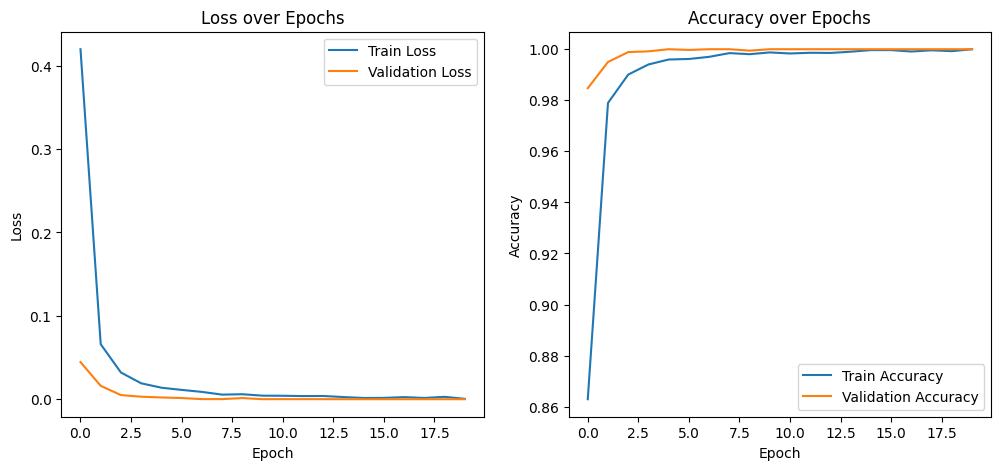


Training history plots generated.


In [ ]:
import matplotlib.pyplot as plt

# 損失のグラフ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 精度のグラフ
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("\nTraining history plots generated.")

In [ ]:
import tensorflow as tf
import numpy as np

# 保存された最も良いモデルをロード
# EarlyStoppingのrestore_best_weights=True が機能しているため、
# model オブジェクトは既に最高の状態の重みを持っているはずですが、
# 念のため、確実にベストモデルをロードします。
model = tf.keras.models.load_model('best_finger_model.h5')

# --- TFLite Converter の作成 ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# --- 量子化の設定 ---
# 最適化設定をデフォルト（量子化を含む）に設定
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 量子化のための代表データセットを指定（精度を保つため推奨）
# これは、モデルが入力として期待するデータの範囲と分布をTFLiteに教えるものです。
# 訓練データセットから数バッチ取得して使用するのが最もシンプルです。
# train_ds は前回のステップで作成したものです。
def representative_data_gen():
    num_samples = 100 # 量子化に使うサンプルの数。多すぎると時間かかる。
    for i, (images, _) in enumerate(train_ds.take(num_samples // BATCH_SIZE + 1)):
        # モデルの入力形状とdtypeに合わせる
        # train_ds から得られる images は既に適切なサイズと float32 になっています
        yield [images[0:1]] # 各バッチから最初の1枚だけを representative として使用

converter.representative_dataset = representative_data_gen

# --- TFLiteモデルへの変換実行 ---
print("Converting Keras model to TFLite and applying quantization...")
tflite_model = converter.convert()
print("Conversion complete.")

# --- TFLiteモデルの保存 ---
tflite_model_path = 'finger_counting_model_quantized.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

Converting Keras model to TFLite and applying quantization...
Saved artifact at '/tmp/tmpdn7es1h3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134168070149840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070159824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070159440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070158480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070158672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070147536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070159248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134168070153488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134167798710928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134167798713232: Tensor

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Conversion complete.
TFLite model saved to: finger_counting_model_quantized.tflite


In [ ]:
from google.colab import files
files.download(tflite_model_path) # 上で保存したTFLiteモデルをダウンロード

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>